In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data=pd.read_csv('vader+textblob+ber+bert_bs score.csv')

In [3]:
data.head()

,Unnamed: 0.1,Unnamed: 0,Price,Open,High,Low,Vol.,Change %,combined_news,negative,...,compound,sentiment_polarity,sentiment_subjectivity,bert_score,sadness,joy,love,anger,fear,surprise
0,0,0,11734.32,11432.09,11759.96,11388.04,212830000.0,2.65%,Georgia downs two Russian warplanes as coun...,0.214,...,-0.9977,-0.055870,0.273787,-0.998241,0.219016,0.007181,0.003590,0.338479,0.429439,0.002296
1,1,1,11782.35,11729.67,11867.11,11675.53,183190000.0,0.41%,Why wont America and Nato help us If they wo...,0.172,...,-0.9801,0.120954,0.340073,-0.996252,0.006003,0.004050,0.001270,0.361401,0.555960,0.071316
2,2,2,11642.47,11781.70,11782.35,11601.52,173590000.0,-1.19%,Rememer that adorale 9 year old who sang at t...,0.166,...,-0.9937,-0.029923,0.420418,-0.998227,0.216387,0.011600,0.001042,0.148420,0.618748,0.003802
3,3,3,11532.96,11632.81,11633.78,11453.34,182550000.0,-0.94%,U.S. refuses Israel weapons to attack Iran ...,0.149,...,-0.9843,-0.020781,0.384336,-0.988580,0.826599,0.012968,0.001446,0.119980,0.037848,0.001158
4,4,4,11615.93,11532.07,11718.28,11450.89,159790000.0,0.72%,All the experts admit that we should legalise...,0.173,...,-0.9801,0.051094,0.406349,-0.980323,0.014240,0.009689,0.000816,0.960365,0.014139,0.000750


In [4]:
data=data.drop(['Unnamed: 0.1','Unnamed: 0'],axis=1)

In [5]:
cor=data.corr(numeric_only=True)

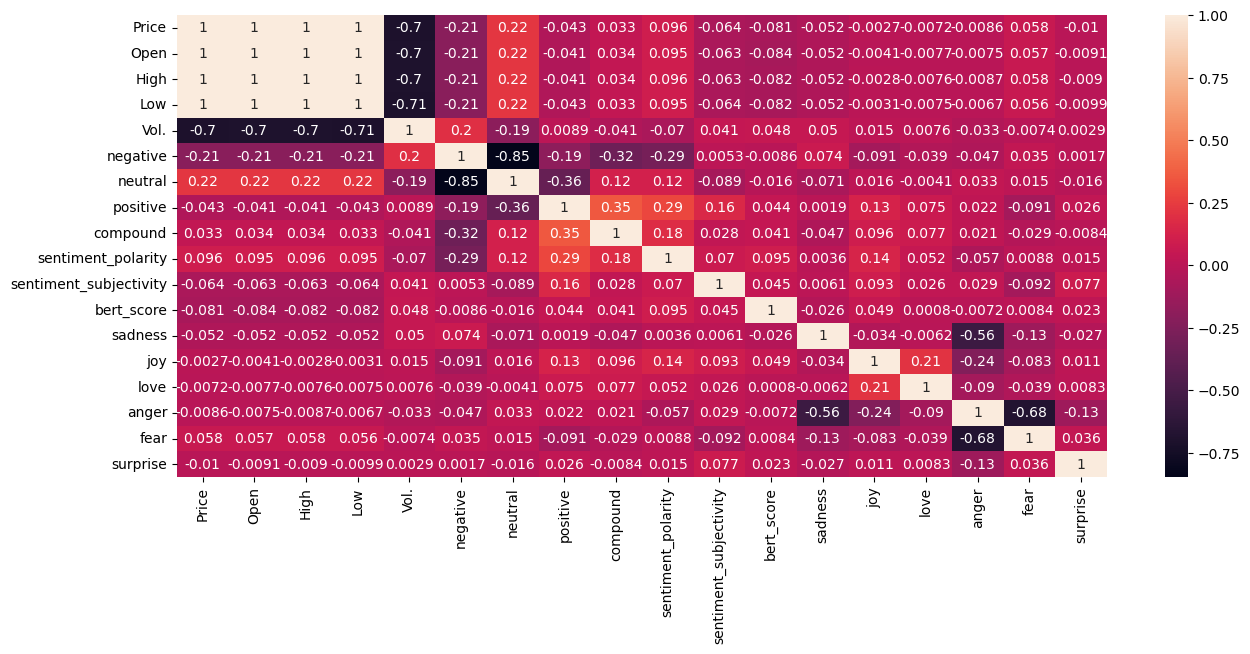

In [6]:
plt.figure(figsize=(15,6))
sns.heatmap(cor,annot=True)
plt.show()

In [7]:
data.columns

Index(['Price', 'Open', 'High', 'Low', 'Vol.', 'Change %', 'combined_news',
       'negative', 'neutral', 'positive', 'compound', 'sentiment_polarity',
       'sentiment_subjectivity', 'bert_score', 'sadness', 'joy', 'love',
       'anger', 'fear', 'surprise'],
      dtype='object')

In [8]:
def data_processing_simple(data,n):
    X=[]
    y=[]
    for i in range(len(data)-n):
        X.append(data.iloc[i:i+5,0])
        y.append(data.iloc[i+5,0])
    return np.array(X),np.array(y)    


def data_processing_vader(data,n):
    X=[]
    y=[]
    for i in range(len(data)-n):
        X.append(data.iloc[i:i+5,[0,4,7,8,9,10]])
        y.append(data.iloc[i+5,0])
    return np.array(X),np.array(y)    

def data_processing_textblob(data,n):
    X=[]
    y=[]
    for i in range(len(data)-n):
        X.append(data.iloc[i:i+5,[0,11,12]])
        y.append(data.iloc[i+5,0])
    return np.array(X),np.array(y)    

def data_processing_bert(data,n):
    X=[]
    y=[]
    for i in range(len(data)-n):
        X.append(data.iloc[i:i+5,[0,13]])
        y.append(data.iloc[i+5,0])
    return np.array(X),np.array(y)   

def data_processing_bert_2(data,n):
    X=[]
    y=[]
    for i in range(len(data)-n):
        X.append(data.iloc[i:i+5,[0,14,15,16,17,18,19]])
        y.append(data.iloc[i+5,0])
    return np.array(X),np.array(y)   

In [9]:
n=7 # past one week obs
X_normal,y_normal=data_processing_simple(data,n)
X_vader,y_vader=data_processing_vader(data,n)
X_textblob,y_textblob=data_processing_textblob(data,n)
X_bert,y_bert=data_processing_bert(data,n)
X_bert2,y_bert2=data_processing_bert_2(data,5)

In [10]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Input,LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import random
from keras.optimizers import Adam

In [11]:
def set_random_seed(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)
    
    
def training_evaluating(X, y,seed=42):
    set_random_seed(seed)
    
    train_size = int(len(X) * 0.7)
    X_train, X_test, y_train, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]
    
    scaler = MinMaxScaler()
    scaler.fit(X_train.reshape(-1, X_train.shape[-1]))
    X_train_scaled = scaler.transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
    X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape) 
    
    scaler_y = MinMaxScaler()
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).reshape(-1)
    y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).reshape(-1)
    
    # Building the model
    model = Sequential()
    model.add(Input(shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))  # Input layer specifying the shape
    model.add(LSTM(50, return_sequences=True))
    model.add(LSTM(50))
    model.add(Dense(1)) 
    
    # Compiling the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    
    # Fit the model
    model.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=30, validation_split=0.2, verbose=1)
    
    # Evaluating
    y_pred_scaled = model.predict(X_test_scaled)
    y_pred_original = scaler_y.inverse_transform(y_pred_scaled)
    
    # Compute R-squared value
    r_squared = r2_score(y_test, y_pred_original)
    
    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(y_test, label='True Value')
    plt.plot(y_pred_original, label='Predicted Value')
    plt.title('True vs Predicted Values')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()
    
    return y_test,y_pred_original,r_squared


Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 0.0873 - val_loss: 0.0826
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0064 - val_loss: 0.0019
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0010 - val_loss: 7.6150e-04
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.3352e-04 - val_loss: 5.1586e-04
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.0753e-04 - val_loss: 4.1176e-04
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.1742e-04 - val_loss: 3.7790e-04
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.4669e-04 - val_loss: 4.2802e-04
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.9574e-04 - val_loss: 4.1264e-04
Epoch 10/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.6988e-04 - val_loss: 3.6815e-04
Epoch 11/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.5645e-04 - val_loss: 3.2465e-04
Epoch 12

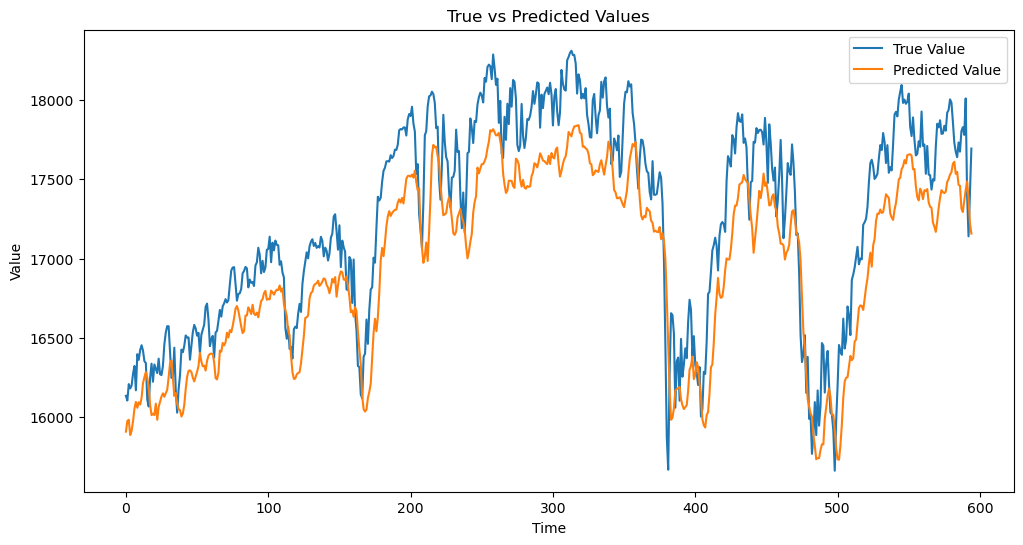

In [12]:
y_test,y_pred_vader,r_vader=training_evaluating(X_vader,y_vader)

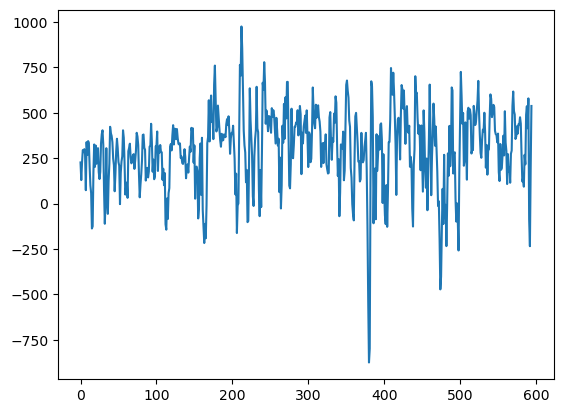

In [13]:
resid=y_test.reshape(-1,1)-y_pred_vader
plt.plot(resid)
plt.show()

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 0.1010 - val_loss: 0.1165
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0105 - val_loss: 0.0021
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0011 - val_loss: 0.0025
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.7587e-04 - val_loss: 0.0014
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.2995e-04 - val_loss: 0.0011
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.1235e-04 - val_loss: 8.3155e-04
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.0133e-04 - val_loss: 6.5749e-04
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.9229e-04 - val_loss: 5.6082e-04
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.8373e-04 - val_loss: 5.0617e-04
Epoch 10/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.7562e-04 - val_loss: 4.6452e-04
Epoch 11/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.6890e-04 - val_loss: 4.2616e-04
Epoch 12/50
37/

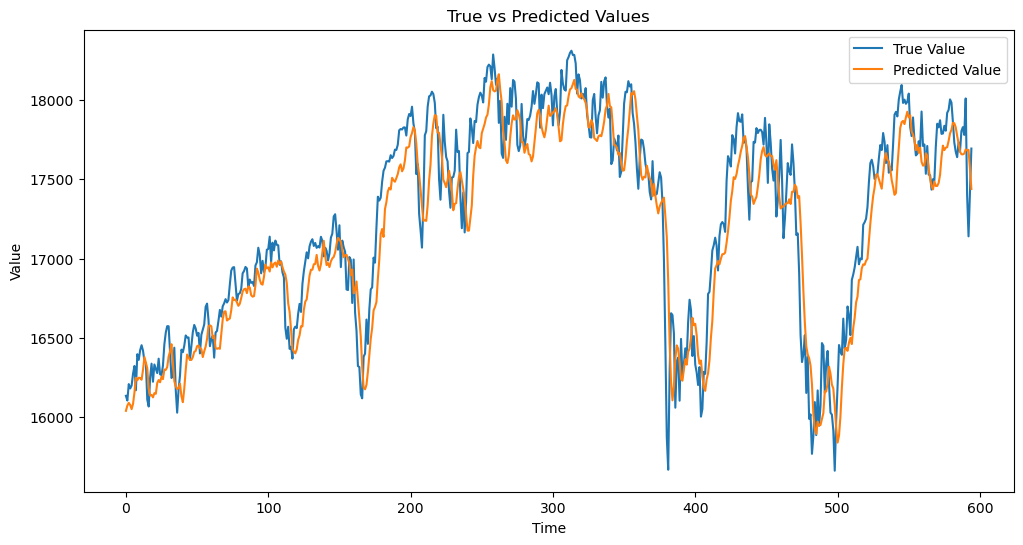

In [14]:
y_test,y_pred_textblob,r_textblob=training_evaluating(X_textblob,y_textblob)

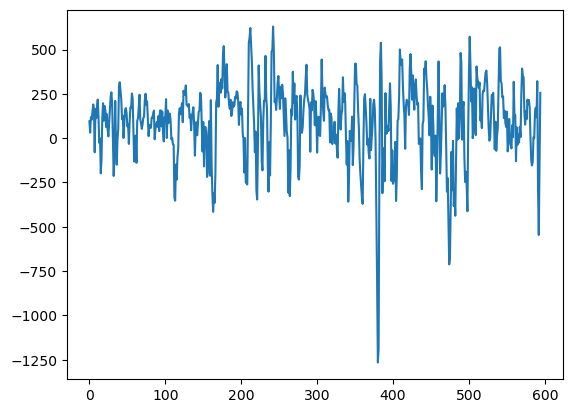

In [15]:
resid=y_test.reshape(-1,1)-y_pred_textblob
plt.plot(resid)
plt.show()

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.1155 - val_loss: 0.0568
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0054 - val_loss: 0.0067
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0015 - val_loss: 4.4640e-04
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.8069e-04 - val_loss: 0.0019
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.8211e-04 - val_loss: 0.0023
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.8254e-04 - val_loss: 0.0022
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.7864e-04 - val_loss: 0.0020
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.7347e-04 - val_loss: 0.0017
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.6945e-04 - val_loss: 0.0015
Epoch 10/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.6601e-04 - val_loss: 0.0013
Epoch 11/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.6298e-04 - val_loss: 0.0011
Epoch 12/50
37/37 ━━━━━━━━━━━━━━

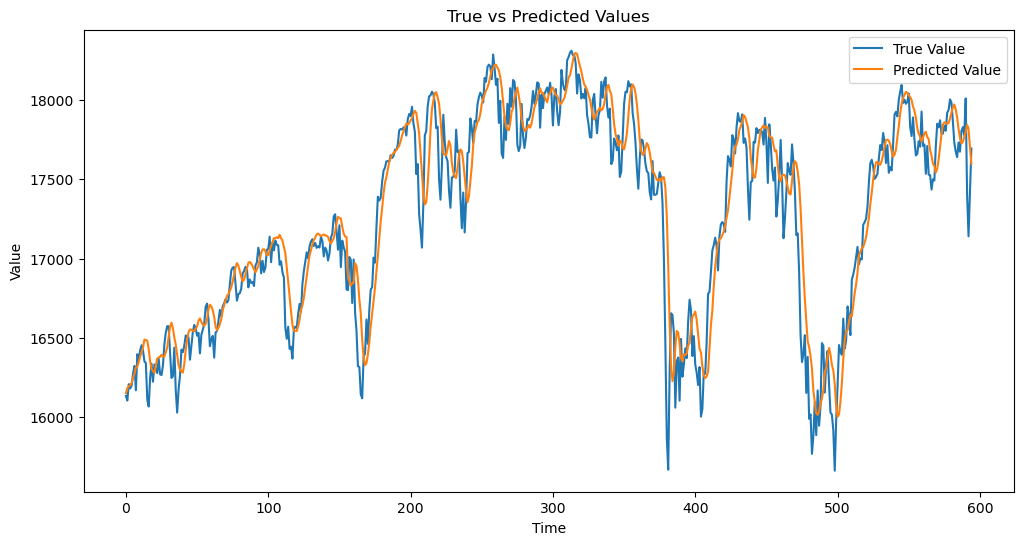

In [16]:
y_test,y_pred_bert,r_bert=training_evaluating(X_bert,y_bert)

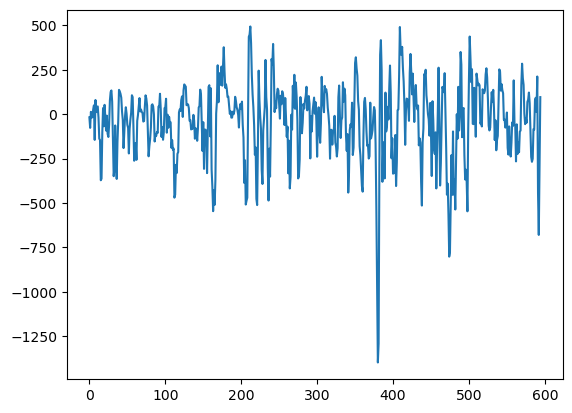

In [17]:
resid=y_test.reshape(-1,1)-y_pred_bert
plt.plot(resid)
plt.show()

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0772 - val_loss: 0.0821
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0105 - val_loss: 8.9429e-04
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0010 - val_loss: 0.0026
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.1925e-04 - val_loss: 0.0020
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.7576e-04 - val_loss: 0.0018
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.5193e-04 - val_loss: 0.0014
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.3405e-04 - val_loss: 0.0011
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.2510e-04 - val_loss: 8.5642e-04
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.2040e-04 - val_loss: 6.8483e-04
Epoch 10/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.1807e-04 - val_loss: 5.5761e-04
Epoch 11/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.1758e-04 - val_loss: 4.6616e-04
Epoch 12/50
37/37 ━━━

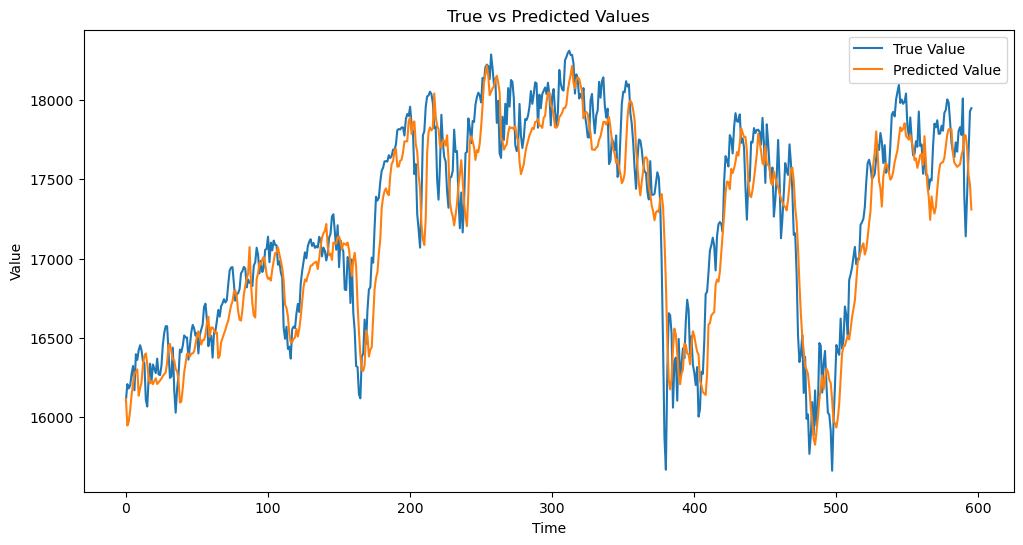

In [18]:
y_test,y_pred_bert2,r_bert2=training_evaluating(X_bert2,y_bert2)

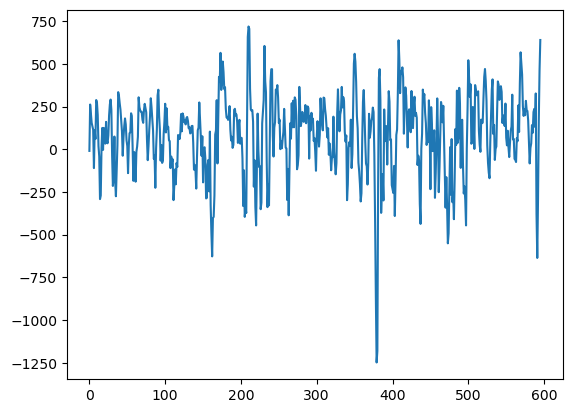

In [19]:
resid=y_test.reshape(-1,1)-y_pred_bert2
plt.plot(resid)
plt.show()

In [20]:
def training_evaluating_normal(X, y,seed=42):
    
    set_random_seed(seed)
    
    train_size = int(len(X) * 0.7)
    X_train, X_test, y_train, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]
    
    # Scaling the data
    scaler_X = MinMaxScaler()
    scaler_X.fit(X_train.reshape(-1, X_train.shape[-1]))
    X_train_scaled = scaler_X.transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
    X_test_scaled = scaler_X.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
    
    scaler_y = MinMaxScaler()
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).reshape(-1)
    y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).reshape(-1)
    
    # Reshape data to be 3D [samples, time steps, features]
    X_train_scaled = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
    X_test_scaled = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))
    
    # Building the model
    model = Sequential()
    model.add(Input(shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))  # Input layer specifying the shape
    model.add(LSTM(100, return_sequences=True))
    model.add(LSTM(50))
    model.add(Dense(1)) 
    
    # Compiling the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    
    # Fit the model
    model.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=32, validation_split=0.2, verbose=1)
    
    # Evaluating
    y_pred_scaled = model.predict(X_test_scaled)
    y_pred_original = scaler_y.inverse_transform(y_pred_scaled)
    
    # Compute R-squared value
    r_squared = r2_score(y_test, y_pred_original)
    
    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(y_test, label='True Value')
    plt.plot(y_pred_original, label='Predicted Value')
    plt.title('True vs Predicted Values')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    return r_squared,y_pred_original,y_test

Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.1561 - val_loss: 6.6082e-04
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0056 - val_loss: 0.0079
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0020 - val_loss: 0.0025
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0013 - val_loss: 4.1554e-04
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.5396e-04 - val_loss: 5.9977e-04
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.0234e-04 - val_loss: 0.0018
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.9626e-04 - val_loss: 0.0028
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6115e-04 - val_loss: 0.0034
Epoch 9/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5086e-04 - val_loss: 0.0036
Epoch 10/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.4605e-04 - val_loss: 0.0036
Epoch 11/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.4131e-04 - val_loss: 0.0034
Epoch 12/50
35/35 ━━━━━━━━━━━━━━━

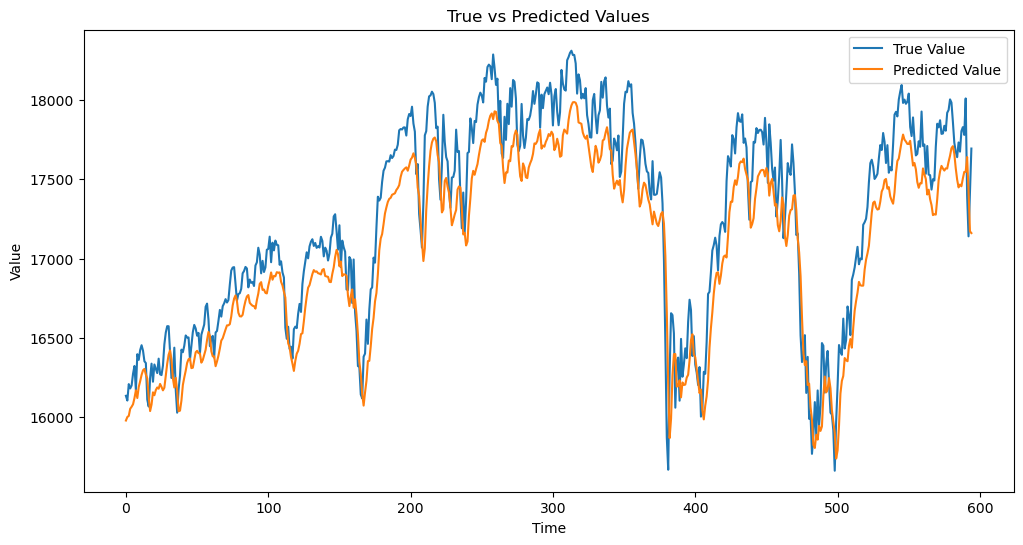

In [21]:
r_normal,y_pred_normal,y_test=training_evaluating_normal(X_normal,y_normal)

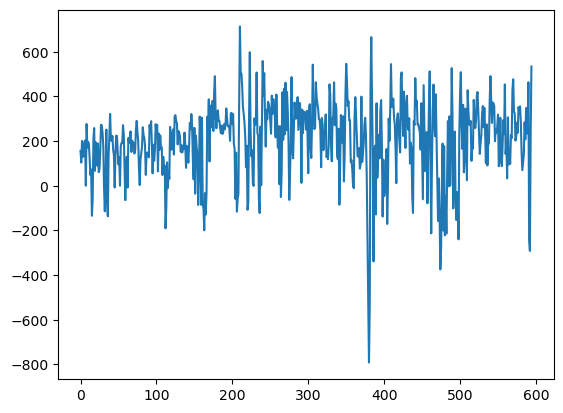

In [22]:
resid=y_test.reshape(-1,1)-y_pred_normal
plt.plot(resid)
plt.show()

In [29]:
r2_score=[r_vader,r_textblob,r_bert,r_bert2,r_normal]
pd.DataFrame(r2_score,index=['vader','textblob','bert','bert_tuned','normal'],columns=['r2_score'])

,r2_score
vader,0.680813
textblob,0.867332
bert,0.885703
bert_tuned,0.854689
normal,0.835450


In [25]:
# sudden peaks or drops cannot be captured by normal model.
# by incorporating news we can capture sudden peaks or drops.